# Make globally averaged time series of ocean variables

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr
xr.set_options(enable_cftimeindex=True)
#import cf_xarray # use cf-xarray so that we can use CF attributes

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd


import matplotlib as mpl
import matplotlib.pyplot as plt

#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/xarray/core/options.py:115: FutureWarning: The enable_cftimeindex option is now a no-op and will be removed in a future version of xarray.
  warnings.warn(


In [2]:
# define constants

speryr=60*60*24*365

# unit conversion for fgco2 to PgC/yr
# kgC/m2/s * speryr * 1e3 g/kg * 1e-15 Pg/g


ZJperJ = 1e-21


PgperKg = 1e-12

In [3]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist= ['CESM2']

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

modelcolors=['dodgerblue','mediumvioletred','red','olive','cyan','gray']


varlist_load=['hfds','fgco2']#,'spco2',]
unitslist=['W m-2'] #'kgC m-2 s-1', 

varlist=varlist_load

In [4]:
# initialize a dictionary to hold all of the data
data_dict={}

In [5]:
def weighted_temporal_mean(ds, var):
    """
    takes an annual average weighted by days in each month

    Args:
    - dataset: xarray dataset with monthly resolution data
    - var: variable name to be averaged

    Returns:
    - the weighted average

    Example Usage: 
    
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="YS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="YS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

### Load Grid Info

In [6]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    if model =='GISS_E2.1':
        # no grid data exists at this time
        # do nothing
        print(model +' does not have grid info')
    else:
        print(model +' getting grid info')
    
        # get area of gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
        areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

        # get area of ocean gridcells
        filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
        areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
        if model =='CESM2':
            areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

        # add to the dictionary
        data_dict[model +'_areacella'] = areacella
        data_dict[model +'_areacello'] = areacello


CESM2 getting grid info


In [7]:
#print(areacello.areacello.sum(dim=['nlat','nlon']))

### Load Data

In [8]:
# this loads all variables in varlist for all experiments in runlist and models in modellist

#modellist=['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR']
#modellist=['HadCM3LC-Bris']
#----loop over models----#

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist_load[v]
            print('loading variable: ' +var)
            
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            #----loop over filenames----#
            # some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            #----- Dealing with GISS----#
            # GISS does not have a "time" index, and instead just a list of years
            # lets replace the "year" dimension (data is called "years")
            # with a cftime object called "time" so it matches the other models
            # some variables don't have the variable that defines years at all
            if ((model == 'GISS_E2.1') and ('time' not in dsmerge_f)):         
                if 'year' in dsmerge_f: # if it has a variable called year, use that to make the time index
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in dsmerge_f.year]
                else: # if it does not have a variable for year, use the size of the year dimension to make the time index
                    startyear=[1850, 1950, 1950] # these are the start years for each experiment for GISS
                    years = np.arange(startyear[r], startyear[r]+len(dsmerge_f['year']))
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in years]
                
                # Create a new DataArray with cftime objects
                time_da = xr.DataArray(time_index, dims='year')
                # Add time_da as a coordinate to the dataset
                dsmerge_f.coords['time'] = time_da
                # Now, swap dimensions from 'years' to 'time'
                dsmerge_f = dsmerge_f.swap_dims({'year': 'time'})
                # drop the year variable
                #dsmerge_f = dsmerge_f.drop_vars('year')
            
            #----correct the name of the lat lon dimensions
            if ((model =='HadCM3LC-Bris') and ('lat' not in dsmerge_f)):
                #-- change latitude and longitude to lat and lon for HadCM3
                dsmerge_f = dsmerge_f.rename({'longitude': 'lon','latitude': 'lat'})
            
            #----correct variable names----# 
            if 'nep' in dsmerge_f: # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep') # to remove it from the dataset
            
            if model =='HadCM3LC-Bris':
                if 'GBMVegCarb_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cVeg'] = dsmerge_f['GBMVegCarb_srf']
                if 'soilCarbon_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cSoil'] = dsmerge_f['soilCarbon_srf']
                if 'NPP_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['npp'] = dsmerge_f['NPP_mm_srf']
                if 'unknown' in dsmerge_f: #HadCM3 
                    dsmerge_f['nbp'] = dsmerge_f['unknown']
                if 'field1560_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['fgco2'] = dsmerge_f['field1560_mm_srf']
                if 'soilResp_mm_srf' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['rh'] = dsmerge_f['soilResp_mm_srf']
                if 'GPP_mm_srf gpp' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['gpp'] = dsmerge_f['GPP_mm_srf gpp']
                 
                
            #----check units and convert if necessary----#
            if var in dsmerge_f: 
                if model =='CESM2':
                    if dsmerge_f[var].units == 'gC/m^2/s':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    # stock variables
                    elif dsmerge_f[var].units == 'gC/m^2':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2'

                # the units for cVeg in GISS look like they MUST be in gC rather than kgC 
                # CHANGING THE UNIT - even though it is reported as kgC, assuming it is in gC
                if ((var == 'cVeg') and (model == 'GISS_E2.1')):
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC

                
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                #else: # this should now be obsolete
                #    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                #             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            #----merge all variables into one dataset----#
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                if (dsmerge_v['cLitter'].notnull().all()): #litter is sometimes missing. Would be good to make this more general but dealing with this problem for now.
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil']+dsmerge_v['cLitter'] 
                else: 
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil'] 
                
        #----save output to a dictionary----#
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


#modellist=modellist_orig
#varlist=varlist_analyze

loading model: CESM2
loading run: *lat10
loading variable: hfds
loading variable: fgco2
adding CESM2 flat10 to dict
loading run: *zec
loading variable: hfds
loading variable: fgco2
adding CESM2 flat10_zec to dict
loading run: *cdr
loading variable: hfds
loading variable: fgco2
adding CESM2 flat10_cdr to dict


In [9]:
filenamelist= np.sort(glob.glob(searchpath))
filenamelist
#ds_try2 = xr.open_dataset(file, use_cftime=True)

array(['/glade/campaign/cgd/tss/people/aswann/flat10/CESM2/flat10-cdr/b.e21.B1850.f09_g17.FLAT10-cdr.001.pop.h.ts.allyears.fgco2.nc'],
      dtype='<U123')

In [10]:
'''# this loads all variables in varlist for all experiments in runlist and models in modellist
#modellist=['CESM2']#['NorESM2-LM']
#modellist_safe = ['CESM2']#['NorESM2']

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    # loop over experiments
    for r in range(len(runlist)):
        run = runlist_wc[r]

        # loop over variables
        for v in range(len(varlist)):
            var=varlist[v]
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            # loop over filenames. some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                ds = xr.open_dataset(file, use_cftime=True)

                # fix the time dimension in CESM which ends up with the date registering as the month after it should
                # if model=='CESM2':
                #     attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
                #     time_bounds = ds.cf.get_bounds('time')
                #     time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
                #     ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
                #     ds.time.attrs, ds.time.encoding = attrs, encoding
                
                if f==0: #if it's the first variable then create the dataset
                    dsmerge_f = ds
                else:
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            
                
            # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
            if 'nep' in dsmerge_f:
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep')
                
            # check units and convert if necessary - at the moment this is just CESM for carbon variables
            #if ds[veg].units != unitslist[v]:
                # the unit does not match what we expect, 
                # convert the unit and update the metadata
            # At the moment this only applies to CESM, but should catch the CESM units and not others
            # flux variables
            # test first to see if the variable exists. nbp is missnamed in one model
            if var in dsmerge_f: 
                if dsmerge_f[var].units == 'gC/m^2/s':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                # stock variables
                elif dsmerge_f[var].units == 'gC/m^2':
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                    dsmerge_f[var].attrs['units'] = 'kg m-2'
                elif dsmerge_f[var].units == 'mmol/m^3 cm/s':
                    dsmerge_f[var]=dsmerge_f[var]* 1e-8* 12 # convert from mmol/m^3 cm/s to kgC/m2/s 
                    dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                #if 'time' in ds:
                nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                             coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                #else:
                #    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                #             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray

            
            # merge all variables into one dataset
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f],compat='override')

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                dsmerge_v['cTot'] = dsmerge_v['cVeg'] + dsmerge_v['cSoil'] + dsmerge_v['cLitter']
                
                
        
        # save output to a dictionary
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v
'''

"# this loads all variables in varlist for all experiments in runlist and models in modellist\n#modellist=['CESM2']#['NorESM2-LM']\n#modellist_safe = ['CESM2']#['NorESM2']\n\n# loop over models\nfor m in range(len(modellist)):\n    model=modellist[m]\n\n    # loop over experiments\n    for r in range(len(runlist)):\n        run = runlist_wc[r]\n\n        # loop over variables\n        for v in range(len(varlist)):\n            var=varlist[v]\n            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'\n            if model =='CESM2':\n                # all models have a var_ filename except CESM\n                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'\n            \n            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim\n\n            # loop over filenames. some variables are stored in multiple files\n            # this should be possible with xr.open_mfdataset but it isn't

In [11]:
#attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
#time_bounds = ds.cf.get_bounds('time')
#time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
#ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
#ds.time.attrs, ds.time.encoding = attrs, encoding

In [12]:
#time_bounds = ds.cf.get_bounds('time')
#ds.cf

In [13]:
ds=data_dict['CESM2' +'_' +runlist[0]]

In [14]:
ds

<xarray.Dataset>
Dimensions:     (nlat: 384, nlon: 320, time: 2520, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
  * time        (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    hfds        (time, nlat, nlon) float32 ...
    time_bound  (time, d2) object 0001-01-01 02:00:00 ... 0211-01-01 00:00:00
    fgco2       (time, nlat, nlon) float32 ...
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 20:13:01 2024: ncatted -O -a long_name,hfds...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

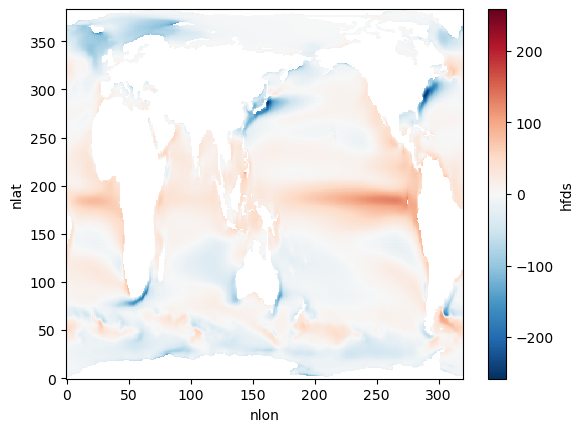

In [15]:
ds.hfds.mean(dim='time').plot()

In [16]:
# areacello is renamed from TAREA

areacello

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320)
Coordinates:
    TLAT       (nlat, nlon) float64 ...
    TLONG      (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    areacello  (nlat, nlon) float64 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Attributes:
    title:             b.e21.B1850.f09_g17.FLAT10-esm.001
    history:           Tue May 14 14:27:19 2024: ncrename -v TAREA,areacello ...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-01 at 15:42:02.2
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

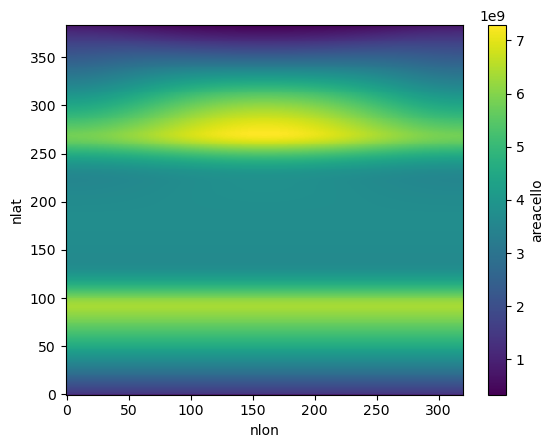

In [17]:
areacello.areacello.plot()

In [18]:
area_m2 = areacello['areacello'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)

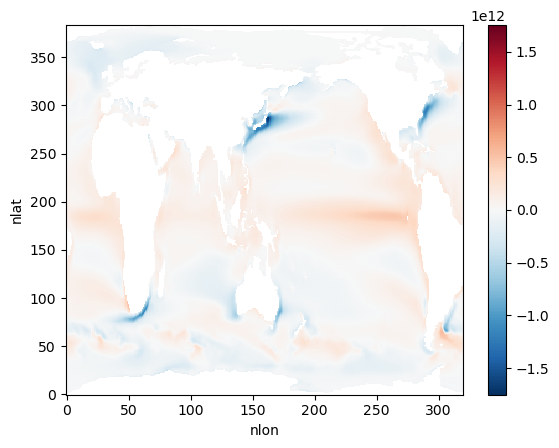

In [19]:
((ds.hfds.mean(dim='time'))*area_m2).plot()

In [20]:
'''
tmp = (ds2015[v] * dz_m_150m).sum(dim='z_t_150m') # units = mmolC/m2
tmp = tmp * area_m2 # units = mmol C/gridcell
tmp = tmp.sum(dim=('nlon','nlat')) # mmol C in the ocean
'''

"\ntmp = (ds2015[v] * dz_m_150m).sum(dim='z_t_150m') # units = mmolC/m2\ntmp = tmp * area_m2 # units = mmol C/gridcell\ntmp = tmp.sum(dim=('nlon','nlat')) # mmol C in the ocean\n"

In [21]:

heatflux_Wm2=ds.hfds # in units of W/m2

total_heatflux_W=heatflux_Wm2*area_m2



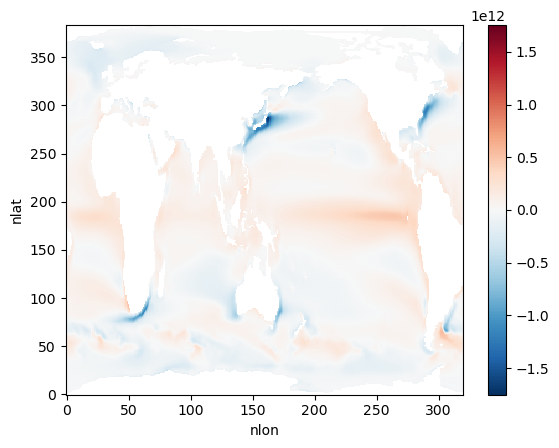

In [22]:

total_heatflux_W.mean(dim='time').plot()

In [23]:
# W/m2 = J/m2/s => *speryr * 1e-21 ZJ/J * m2 of ocean = ZJ/yr

total_heatflux_ZJyr=total_heatflux_W*ZJperJ*speryr


global_heatflux_ZJyr = total_heatflux_ZJyr.sum(dim=['nlat','nlon'])

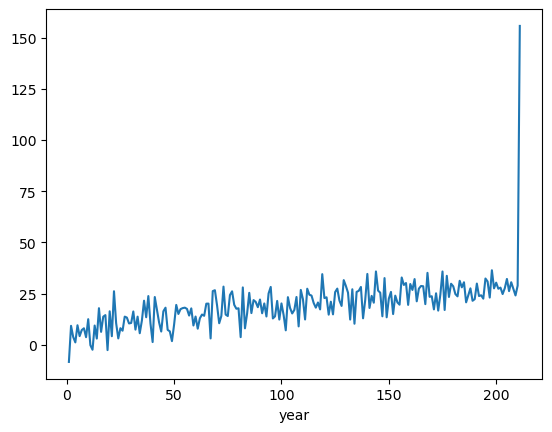

In [24]:
global_heatflux_ZJyr.groupby(global_heatflux_ZJyr['time.year']).mean(dim='time').plot()

In [25]:
global_heatflux_ZJyr

<xarray.DataArray (time: 2520)>
array([122.59805054,  89.26921305, 115.15446606, ..., 153.26251381,
       166.89550201, 155.79751246])
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00

In [26]:
# convert data array to data set
ds_global_heatflux_ZJyr = global_heatflux_ZJyr.to_dataset(name='hfds')

# add metadata
ds_global_heatflux_ZJyr['hfds'].attrs = {'units': 'ZJ yr-1'}

In [27]:
# show metadata
ds_global_heatflux_ZJyr

<xarray.Dataset>
Dimensions:  (time: 2520)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
Data variables:
    hfds     (time) float64 122.6 89.27 115.2 20.19 ... 87.12 153.3 166.9 155.8

## Save output as netcdf files

In [28]:
## for each of the runs

# the folder names and file names don't match
folders = ['flat10',  'flat10-zec', 'flat10-cdr']
names = ['FLAT10-esm' ,'FLAT10-zec', 'FLAT10-cdr']
# runlist defined above

for r in range(3):
    print('loading CESM2 ' +runlist[r])
    ds=data_dict['CESM2' +'_' +runlist[r]]
    
    #heatflux_Wm2=ds.hfds # in units of W/m2
    #total_heatflux_W=heatflux_Wm2*area_m2 # in units of W, which is J/s (rather than W/m2)
    #total_heatflux_ZJyr=total_heatflux_W*ZJperJ*speryr
    
    total_heatflux_ZJyr=(ds.hfds)*area_m2*ZJperJ*speryr
    
    global_heatflux_ZJyr = total_heatflux_ZJyr.sum(dim=['nlat','nlon'])

    # convert data array to data set
    ds_global_heatflux_ZJyr = global_heatflux_ZJyr.to_dataset(name='hfds')
    
    # add metadata
    ds_global_heatflux_ZJyr['hfds'].attrs = {'units': 'ZJ yr-1'}
    ds_global_heatflux_ZJyr.attrs = {'experiment': runlist[r], 'model': model}
    
    filename = 'b.e21.B1850.f09_g17.' +names[r] +'.001.pop.h.ts.allyears.' +'hfds_globalmean.nc'
    ##filepath = outputdir +'CESM2/' +folders[r] +'/'  
    filepath = outputdir +'CESM2/globalmean/'   # put in a seperate folder since the naming convention makes it harder to tell apart

    # add metadata with units etc

    # save the file
    print('saving ' +filepath +filename)
    ds_global_heatflux_ZJyr.to_netcdf(filepath +filename)


    # also add the data arryas to the dictionary
    # save output to a dictionary
    print('adding ' +model +' ' +runlist[r] +' global ocean heat flux to dict')
    data_dict[model +'_' +runlist[r] +'hfdsglobal'] = ds_global_heatflux_ZJyr

loading CESM2 flat10
saving /glade/campaign/cgd/tss/people/aswann/flat10/CESM2/globalmean/b.e21.B1850.f09_g17.FLAT10-esm.001.pop.h.ts.allyears.hfds_globalmean.nc
adding CESM2 flat10 global ocean heat flux to dict
loading CESM2 flat10_zec
saving /glade/campaign/cgd/tss/people/aswann/flat10/CESM2/globalmean/b.e21.B1850.f09_g17.FLAT10-zec.001.pop.h.ts.allyears.hfds_globalmean.nc
adding CESM2 flat10_zec global ocean heat flux to dict
loading CESM2 flat10_cdr
saving /glade/campaign/cgd/tss/people/aswann/flat10/CESM2/globalmean/b.e21.B1850.f09_g17.FLAT10-cdr.001.pop.h.ts.allyears.hfds_globalmean.nc
adding CESM2 flat10_cdr global ocean heat flux to dict


## Plot output

In [29]:
# choose one run from dictionary
r=0
ds_global_heatflux_ZJyr = data_dict[model +'_' +runlist[r] +'hfdsglobal']

In [30]:

ds_global_heatflux_ZJyr


<xarray.Dataset>
Dimensions:  (time: 2520)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0211-01-01 00:00:00
Data variables:
    hfds     (time) float64 122.6 89.27 115.2 20.19 ... 87.12 153.3 166.9 155.8
Attributes:
    experiment:  flat10
    model:       CESM2

In [31]:
runlist[r]

'flat10'

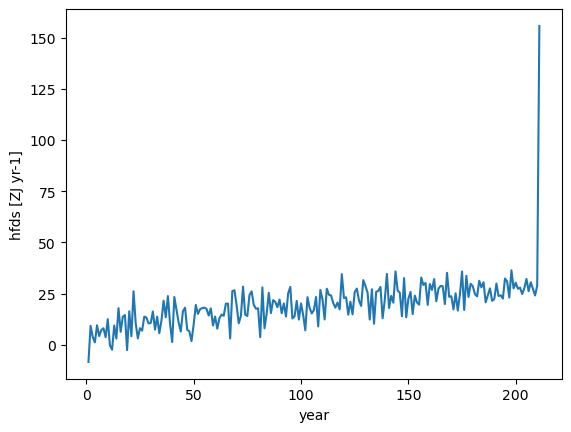

In [32]:

#average from monthly to annual resolution wihtout accounting for different month lengths
ds_global_heatflux_ZJyr['hfds'].groupby(ds_global_heatflux_ZJyr['time.year']).mean(dim='time').plot()

In [33]:
# proper time averaging accounting for different month lengths
global_heatflux_annual_ZJyr=(weighted_temporal_mean(ds_global_heatflux_ZJyr,'hfds'))

Text(0, 0.5, 'Ocean Heat Flux [ZJ/yr]')

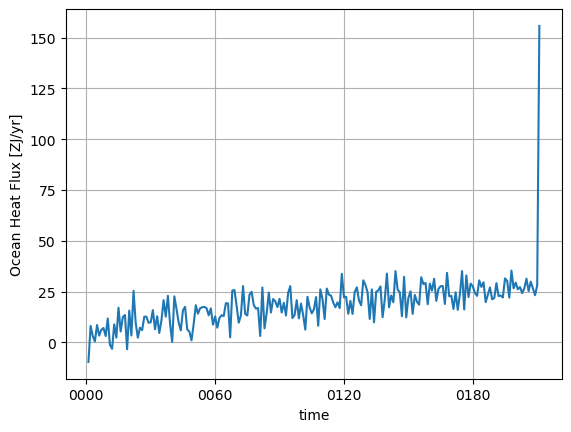

In [34]:
global_heatflux_annual_ZJyr.plot()
plt.grid()
#plt.ylim([-0, 40])
#plt.xlim([0,199])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')

In [35]:
#ts=global_heatflux_annual_ZJyr.sum(dim=['nlat','nlon']).rolling(time=10).mean()

#ts

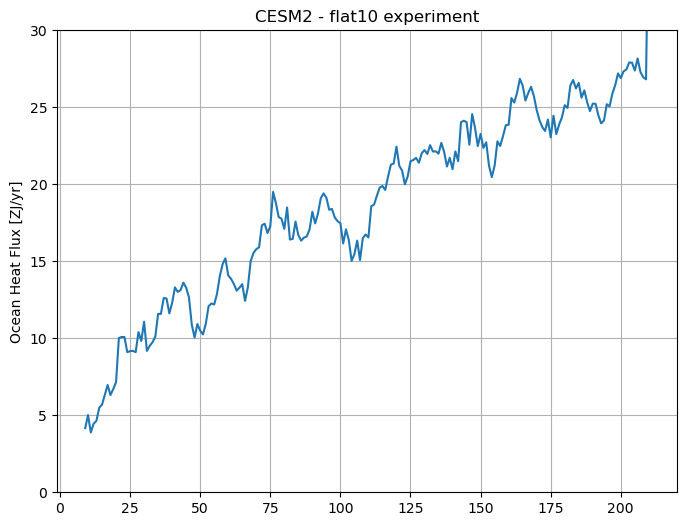

In [36]:
fig = plt.figure(figsize=(8,6))

ts=global_heatflux_annual_ZJyr.rolling(time=10).mean()
plt.plot(ts)
plt.grid()
plt.ylim([-0, 30])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('CESM2 - flat10 experiment')
# save the plot
fig.savefig('figures/' 'oceanheatflux_CESM2_flat10' +'.png', bbox_inches='tight', dpi=1200)


In [37]:
# for flat10 emissions phase
ds=data_dict['CESM2' +'_' +runlist[0]]

# proper time averaging accounting for different month lengths
global_carbonflux_annual=(weighted_temporal_mean(ds,'fgco2')*area_m2*PgperKg*speryr) # include area and unit conversion because we didn't make this global sum yet

Text(0, 0.5, 'Ocean carbon flux [PgC/yr]')

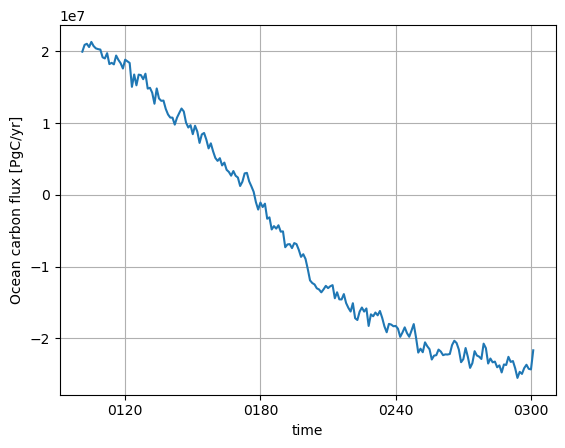

In [38]:
global_carbonflux_annual.sum(dim=['nlat','nlon']).plot()
plt.grid()
plt.ylabel('Ocean carbon flux [PgC/yr]')

## Checking against other output and ways of calculating


In [39]:
## alternative area calculation
import pop_tools

ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
areaA_m2 = area * 1.e-4
dz_m = ds_grid.dz * 0.01

In [40]:
alt_global = ds.hfds * areaA_m2 *speryr *ZJperJ# units = W/gridcell
alt_global_sum = alt_global.sum(dim=('nlon','nlat')) # mmol C in the ocean

Text(0.5, 1.0, 'Alternative calculation using pop tools')

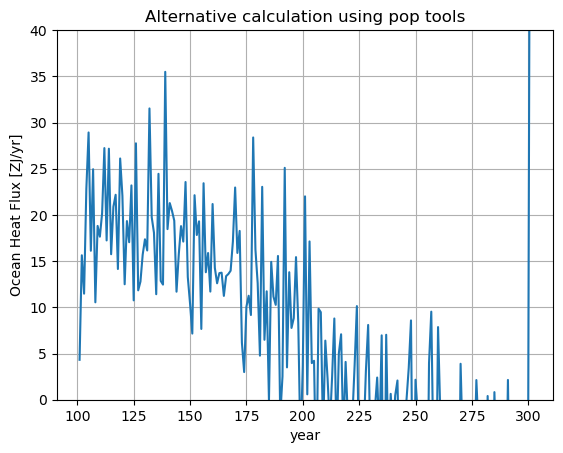

In [41]:
alt_global_sum.groupby(ds['time.year']).mean(dim='time').plot()
plt.grid()
plt.ylim([-0, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Alternative calculation using pop tools')

In [42]:
alt_global_sum

<xarray.DataArray (time: 2400)>
array([117.11673159, 151.02696616,  88.38408737, ..., 102.09925463,
       121.21175939,  82.61158441])
Coordinates:
  * time     (time) object 0101-02-01 00:00:00 ... 0301-01-01 00:00:00

In [43]:
# check a different CESM2 run for a BHIST run
from glob import glob


case1 = 'b.e21.BHIST.f09_g17.ccisens-reference.esmfirebvoc.001'
path1 = '/glade/campaign/cesm/community/bgcwg/HOPE/' + case1 + '/ocn/proc/tseries/month_1'

variables = ['SHF']


files = []

for var in variables:

    files.extend(sorted(glob(f'{path1}/{case1}.pop.h.{var}.185001-201412.nc')))

ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, combine='nested')

## fix time bounds
ds['time'] = ds.time_bound.compute().mean(dim="d2")

In [44]:
ds['SHF']

<xarray.DataArray 'SHF' (time: 1980, nlat: 384, nlon: 320)>
dask.array<open_dataset-SHF, shape=(1980, 384, 320), dtype=float32, chunksize=(1980, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 13:00:00.000001 ... 2014-12-16 12:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Total Surface Heat Flux, Including SW
    units:         watt/m^2
    coordinates:   TLONG TLAT time
    grid_loc:      2110
    cell_methods:  time: mean

In [45]:
# proper time averaging accounting for different month lengths
global_heatflux_annual_ZJyr_HOPE=(weighted_temporal_mean(ds,'SHF')*area_m2*ZJperJ*speryr)

In [46]:
arg=global_heatflux_annual_ZJyr_HOPE.sum(dim=['nlat','nlon'])


/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Historical BHIST HOPE run')

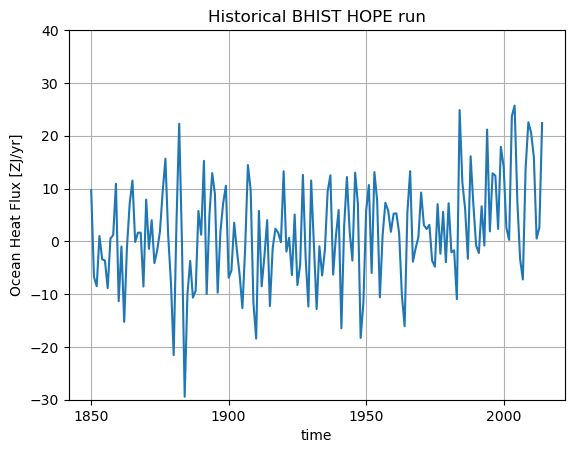

In [47]:
arg.plot()
plt.grid()
plt.ylim([-30, 40])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Historical BHIST HOPE run')




In [48]:
arg

<xarray.DataArray (time: 165)>
dask.array<sum-aggregate, shape=(165,), dtype=float64, chunksize=(165,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2014-01-01 00:00:00

In [ ]:
# rolling avearge for the time series to smooth it
ts=arg.rolling(time=10).mean()

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


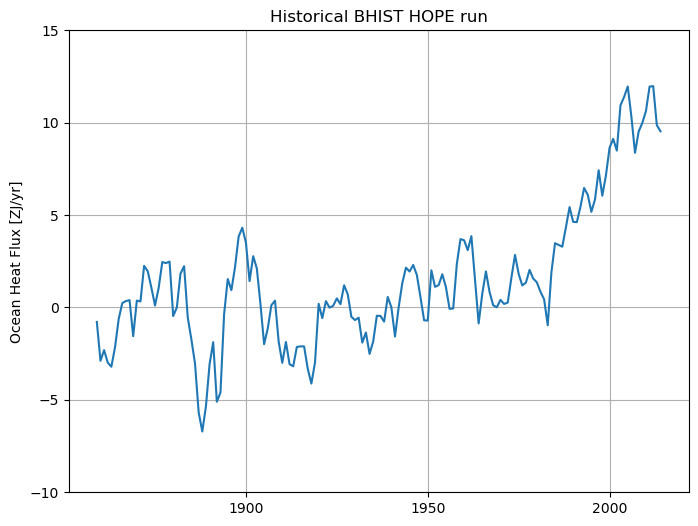

In [51]:
fig = plt.figure(figsize=(8,6))

plt.plot(ts.time, ts)
plt.grid()
plt.ylim([-10, 15])
plt.ylabel('Ocean Heat Flux [ZJ/yr]')
plt.title('Historical BHIST HOPE run')


# save the plot
fig.savefig('figures/' 'oceanheatflux_CESM2_BHIST_HOPE' +'.png', bbox_inches='tight', dpi=1200)